# Data Preparation
First, we'll clone the seminar repository to get access to our raw data and get it ready to use for the network.

In [1]:
!git clone https://github.com/hzi-bifo/seminar-dlmb-2024.git

Cloning into 'seminar-dlmb-2024'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 52 (delta 18), reused 17 (delta 1), pack-reused 0
Receiving objects: 100% (52/52), 884.95 KiB | 7.25 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [2]:
!git clone https://github.com/dev-meesjakob/seminar-dlmb-rnn.git

Cloning into 'seminar-dlmb-rnn'...
remote: Enumerating objects: 319, done.
remote: Counting objects: 100% (319/319), done.
remote: Compressing objects: 100% (240/240), done.
remote: Total 319 (delta 86), reused 297 (delta 68), pack-reused 0
Receiving objects: 100% (319/319), 13.31 MiB | 29.44 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [3]:
!mkdir models/ # make the directory to save the model files in

Here, we read in all sequences and convert them to tensors of one-hot encoded amino acids.

In [4]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder

def readFromFile(path):
  # Read every line of the file
  with open(path, "r") as f:
    data = f.readlines()

  # Remove newline characters
  data = [entry.strip() for entry in data]
  return data

In [5]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer

unk_token = "<UNK>"  # token for unknown words
spl_tokens = ["<UNK>", "<SEP>", "<MASK>", "<CLS>", "<PAD>"]  # special tokens

def prepare_tokenizer_trainer():
  tokenizer = Tokenizer(BPE(unk_token = unk_token))
  trainer = BpeTrainer(special_tokens = spl_tokens, min_frequency = 3)
  return tokenizer, trainer

def train_tokenizer(files):
  tokenizer, trainer = prepare_tokenizer_trainer()
  tokenizer.train(files, trainer) # training the tokenzier
  tokenizer.save("./tokenizer-trained.json")
  tokenizer = Tokenizer.from_file("./tokenizer-trained.json")
  tokenizer.enable_padding(pad_token="<PAD>")
  return tokenizer

tok = train_tokenizer(["/content/seminar-dlmb-2024/dataset/train_seq.txt", "/content/seminar-dlmb-2024/dataset/test_seq.txt"])
tok_big = train_tokenizer(["/content/seminar-dlmb-rnn/dataset/train_seq_big.txt", "/content/seminar-dlmb-rnn/dataset/test_seq_big.txt"])

In [6]:
test_batch = tok.encode_batch(["aanaklfavmqsccstppcalrhmdmcg", "ikngyprds", "qarpphppippap"])
test_batch

[Encoding(num_tokens=16, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=16, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=16, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [37]:
train_seq = readFromFile("/content/seminar-dlmb-2024/dataset/train_seq.txt")
train_label = readFromFile("/content/seminar-dlmb-2024/dataset/train_label.txt")

test_seq = readFromFile("/content/seminar-dlmb-2024/dataset/test_seq.txt")
test_label = readFromFile("/content/seminar-dlmb-2024/dataset/test_label.txt")

# Convert labels to integers
train_label = [int(label) for label in train_label]
test_label = [int(label) for label in test_label]

# big dataset
train_seq_big = readFromFile("/content/seminar-dlmb-rnn/dataset/train_seq_big.txt")
train_label_big = readFromFile("/content/seminar-dlmb-rnn/dataset/train_labels_big.txt")

test_seq_big = readFromFile("/content/seminar-dlmb-rnn/dataset/test_seq_big.txt")
test_label_big = readFromFile("/content/seminar-dlmb-rnn/dataset/test_labels_big.txt")

# Convert labels to integers
train_label_big = [int(label) for label in train_label_big]
test_label_big = [int(label) for label in test_label_big]

In [38]:
# Create DataFrames
df_train = pd.DataFrame({
    'sequence': train_seq,
    'label': train_label,
})

df_test = pd.DataFrame({
    'sequence': test_seq,
    'label': test_label,
})

# big dataset
df_train_big = pd.DataFrame({
    'sequence': train_seq_big,
    'label': train_label_big,
})

df_test_big = pd.DataFrame({
    'sequence': test_seq_big,
    'label': test_label_big,
})

In [39]:
from torch.utils.data import Dataset, DataLoader

class ToxinDatasetReader(Dataset):
  def __init__(self, df: pd.DataFrame):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx: int):
    row = self.df.loc[idx]
    input_protein = row.sequence
    labels = row.label
    return input_protein, labels

train_dat = ToxinDatasetReader(df_train)
test_dat = ToxinDatasetReader(df_test)
val_dat = ToxinDatasetReader(df_train) # use training data as validation data

# big dataset
train_dat_big = ToxinDatasetReader(df_train_big)
test_dat_big = ToxinDatasetReader(df_test_big)
val_dat_big = ToxinDatasetReader(df_train_big) # use training data as validation data

In [40]:
def collate_fn(data):
  seq, labels  = zip(*data)

  labels = torch.tensor(labels)
  batch = tok.encode_batch(seq)

  sequences = torch.tensor([seq.ids for seq in batch])
  masks = torch.tensor([seq.attention_mask for seq in batch])

  return sequences, masks, labels.long()

In [41]:
BATCH_SIZE=32

train_loader = DataLoader(train_dat, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dat, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_loader = DataLoader(val_dat, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# big dataset
train_loader_big = DataLoader(train_dat_big, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader_big = DataLoader(test_dat_big, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_loader_big = DataLoader(val_dat_big, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [30]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size, device):
    super(RNN, self).__init__()

    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.embedding = nn.Embedding(input_size, hidden_size)

    self.rnn = nn.RNN(hidden_size, hidden_size, num_layers=num_layers, nonlinearity="relu")

    self.fc = nn.Linear(hidden_size, output_size)
    self.sigmoid = nn.Sigmoid()

  def forward(self, tokens, masks):
    # initialize hidden state as tensor of zeros
    hidden = torch.zeros(self.num_layers, tokens.size(0), self.hidden_size).requires_grad_().to(self.device)

    # embedding layer at the start for the tokens
    embeddings = self.embedding(tokens)

    # create packed sequence to pass to the rnn layer
    packed_in = nn.utils.rnn.pack_padded_sequence(embeddings, masks.sum(1), batch_first=True, enforce_sorted=False).to(self.device)

    packed_out, hidden = self.rnn(packed_in, hidden)

    # unpack the packed sequence the rnn gave us
    out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

    # get the last valid output for each sequence
    seq_lengths = masks.sum(1) - 1  # Adjusting to zero-based index
    last_outputs = out[range(out.size(0)), seq_lengths]

    # fully connected last layer so use bcewithlogitsloss
    out = self.fc(last_outputs)

    return out

  def get_last_output(self, output, lengths):
    # Extract the last output for each sequence
    last_output = torch.stack([output[i, lengths[i] - 1, :] for i in range(output.size(0))])
    return last_output

In [33]:
import time
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

MODEL_PATH = f"/content/models/"

class Optimization:
  def __init__(self, model, loss_fn, optimizer, device):
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.device = device

    self.train_losses = []
    self.val_losses = []

  def train_step(self, batch, masks, labels):
    batch = batch.to(self.device)
    labels = labels.to(self.device)

    self.model.train()
    outputs = self.model(batch, masks)

    labels = labels.view(-1, 1).float()

    loss = self.loss_fn(outputs, labels)

    loss.backward()

    self.optimizer.step()
    self.optimizer.zero_grad()

    return loss.item()

  def train(self, train_loader, val_loader, batch_size=32, n_epochs=50, n_features=1):
    model_path = MODEL_PATH + f'model_{datetime.now().strftime("%Y-%m-%d %H:%M:%S").replace(" ", "_").replace(":", "_")}'

    for epoch in range(1, n_epochs + 1):
        self.model.rnn.all_weights
        start_time = time.time()
        batch_losses = []

        # training set
        for batch, masks, labels in train_loader:
          loss = self.train_step(batch, masks, labels)
          batch_losses.append(loss)

        training_loss = np.mean(batch_losses)
        self.train_losses.append(training_loss)

        # validation set
        with torch.no_grad():
          batch_val_losses = []
          for batch, masks, labels in val_loader:
            batch = batch.to(self.device)
            labels = labels.to(self.device)

            labels = labels.view(-1, 1).float()

            self.model.eval()
            outputs = self.model(batch, masks)

            val_loss = self.loss_fn(outputs, labels).item()
            batch_val_losses.append(val_loss)

          validation_loss = np.mean(batch_val_losses)
          self.val_losses.append(validation_loss)

        end_time = time.time()
        epoch_duration = end_time - start_time

        print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}\t Epoch duration: {epoch_duration:.1f}s")

    torch.save(self.model.state_dict(), model_path)

  def evaluate(self, test_loader, batch_size=1, n_features=1):

    # test set
    with torch.no_grad():
      predictions = []
      values = []

      for batch, masks, labels in test_loader:
        batch = batch.to(self.device)
        labels = labels.to(self.device)

        labels = labels.view(-1, 1).float()

        self.model.eval()
        outputs = self.model(batch, masks)

        outputs = outputs.cpu()
        labels = labels.cpu()
        predictions.append(outputs.detach().numpy())
        values.append(labels.detach().numpy())

      return predictions, values

  def plot_losses(self):
    plt.plot(self.train_losses, label="Training loss")
    plt.plot(self.val_losses, label="Validation loss")
    plt.legend()
    plt.title("Losses")
    plt.show()
    plt.close()

Using device: cpu
[1/2] Training loss: 0.6748	 Validation loss: 0.6681	 Epoch duration: 2.3s
[2/2] Training loss: 0.6667	 Validation loss: 0.6643	 Epoch duration: 2.3s


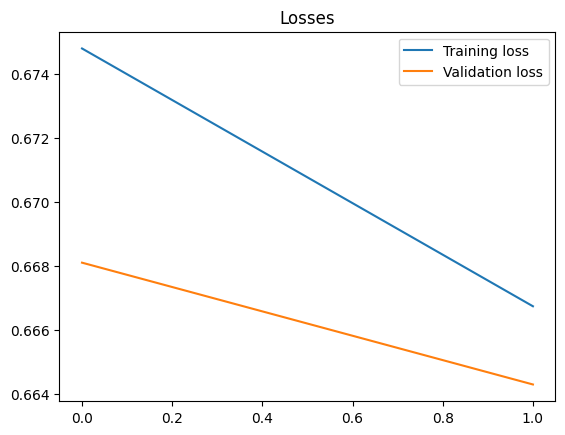

In [36]:
import torch.optim as optim
import glob
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

# Hyperparameters
input_size = tok.get_vocab_size()
output_size = 1
hidden_size = 64
num_layers = 3
n_epochs = 2
learning_rate = 0.003
weight_decay = 0.1

model = RNN(input_size, hidden_size, num_layers, output_size, device)
model.to(device)

# Use glob to find files starting with "model_"
model_files = glob.glob(os.path.join(MODEL_PATH, 'model_*'))

# Check if any model files were found
if model_files:
    # Find the latest file based on modification time
    latest_model_file = max(model_files, key=os.path.getmtime)
    model_path = latest_model_file
    print(f'Latest model file found: {model_path}')
    model.load_state_dict(torch.load(model_path))

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer, device=device)
opt.train(train_loader, val_loader, n_epochs=n_epochs, n_features=input_size)
opt.plot_losses()